# Stack Autoencoder on MNIST

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

### Load MNIST Data

x_train.shape : (60000, 28, 28)
y_train.shape : (60000,)
x_test.shape : (10000, 28, 28)
y_test.shape : (10000,)


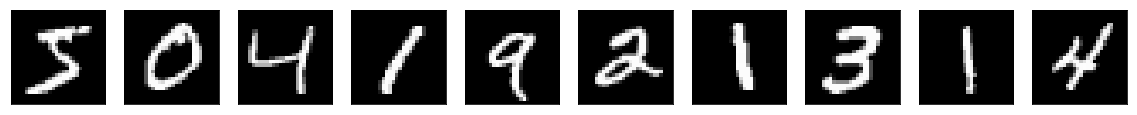

In [5]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("x_train.shape :", x_train.shape)
print("y_train.shape :", y_train.shape)
print("x_test.shape :", x_test.shape)
print("y_test.shape :", y_test.shape)

fig, axes = plt.subplots(nrows=1,ncols=10, figsize=(20,4))
for i in range(10):
    ax = axes[i]
    ax.imshow(x_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Normalization and Flattern 28x28 images into vectors of size 784

x_train.shape : (60000, 784)
x_test.shape : (10000, 784)


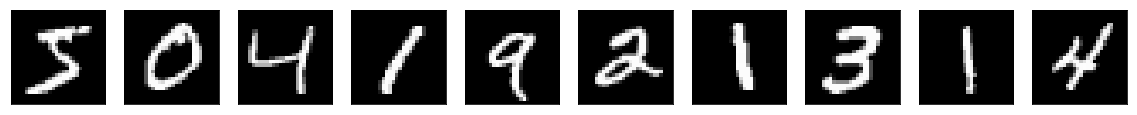

In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print("x_train.shape :", x_train.shape)
print("x_test.shape :", x_test.shape)

fig, axes = plt.subplots(nrows=1,ncols=10, figsize=(20,4))
for i in range(10):
    ax = axes[i]
    ax.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [105]:
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras import regularizers

In [134]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(128, activation='relu')(input_img)
encoded = BatchNormalization()(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
encoder.summary()

# "decoded" is the lossy reconstruction of the input
shared_decoded1 = Dense(64, activation='relu')
shared_decoded2 = Dense(128, activation='relu')
shared_decoded2BN = BatchNormalization()
shared_decoded3 = Dense(784, activation='sigmoid')

decoded1a = shared_decoded1(encoded)
decoded2a = shared_decoded2(decoded1a)
decoded2a = shared_decoded2BN(decoded2a)
decoded3a = shared_decoded3(decoded2a)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
decoded1b = shared_decoded1(encoded_input)
decoded2b = shared_decoded2(decoded1b)
decoded2b = shared_decoded2BN(decoded2b)
decoded3b = shared_decoded3(decoded2b)

# create the decoder model
decoder = Model(encoded_input, decoded3b)
decoder.summary()

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded3a)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_220 (Dense)            (None, 128)               100480    
_________________________________________________________________
batch_normalization_51 (Batc (None, 128)               512       
_________________________________________________________________
dense_221 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_222 (Dense)            (None, 32)                2080      
_________________________________________________________________
batch_normalization_52 (Batc (None, 32)                128       
Total params: 111,456
Trainable params: 111,136
Non-trainable params: 320
_________________________________________________________________
__

In [135]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [173]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s - loss: 0.0908 - val_loss: 0.0883
Epoch 2/10
60000/60000 [==============================] - 6s - loss: 0.0907 - val_loss: 0.0881
Epoch 3/10
60000/60000 [==============================] - 6s - loss: 0.0906 - val_loss: 0.0880
Epoch 4/10
60000/60000 [==============================] - 6s - loss: 0.0905 - val_loss: 0.0879
Epoch 5/10
60000/60000 [==============================] - 6s - loss: 0.0903 - val_loss: 0.0877
Epoch 6/10
60000/60000 [==============================] - 6s - loss: 0.0902 - val_loss: 0.0875
Epoch 7/10
60000/60000 [==============================] - 6s - loss: 0.0901 - val_loss: 0.0875
Epoch 8/10
60000/60000 [==============================] - 6s - loss: 0.0900 - val_loss: 0.0874
Epoch 9/10
60000/60000 [==============================] - 6s - loss: 0.0899 - val_loss: 0.0873
Epoch 10/10
60000/60000 [==============================] - 6s - loss: 0.0898 - val_loss: 0.0872

In [174]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [175]:
print(encoded_imgs.mean())
print(x_test.mean())

-0.0435716
0.132515


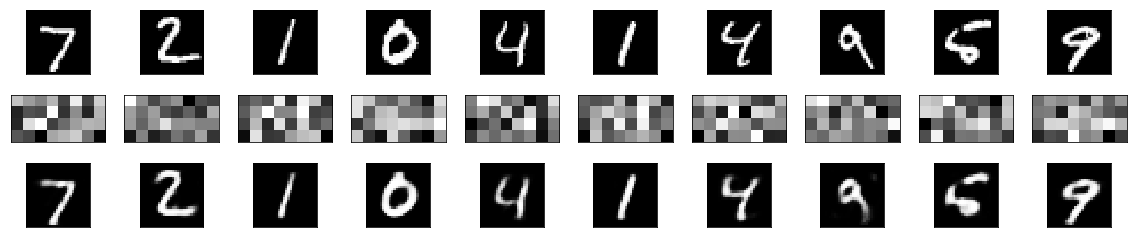

In [176]:
fig, axes = plt.subplots(nrows=3,ncols=10, figsize=(20,4))
for i in range(10):
    ax = axes[0,i]
    ax.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = axes[1, i]
    ax.imshow(encoded_imgs[i].reshape(-1,8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = axes[2,i]
    ax.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)